In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from hybrid_model_v3 import HybridSegModel

from helper import postprocess_logits_with_fill

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Nodule_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type
        
class GE_Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]


        from_folder = "../ge_data/gland"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [35]:
image_size = 128
batch_size = 1 # if not one, be careful about the zero mask batch
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

# test_dataset = GE_Thyroid_Dataset("../ge_data/nodule/all_data.csv", transform = test_augmentation, image_size = image_size)
# test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
test_dataset = GE_Gland_Dataset("../ge_data/gland/test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
image, mask, mask_name, image_type = next(iter(test_dataloader))

In [36]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.)
unique :  tensor([0., 1.])


In [37]:
image_type

('gland',)

In [38]:
# for i in range(20):
#     print(mask_name[i])
#     print(image_type[i])
#     plt.subplot(1,2,1)
#     plt.imshow(image[i][0])
#     plt.subplot(1,2,2)
#     plt.imshow(mask[i][0])
#     plt.show()
    

In [39]:
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val_nodule(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    dice_arr = []
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        if torch.sum(mask) == 0:
            continue
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        
        IOU = IOU_score(output, mask)


        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
        
        dice_arr.append(DICE.item())

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        count += 1
    # return total_loss/count, total_IOU/count, total_DICE/count, dice_arr
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), dice_arr

def val_gland(dataloader, model, device, gland_post_process):
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    dice_arr = []
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        if torch.sum(mask) == 0:
            continue
        outputs = model(image)


        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]
        
        gland_mask = mask
        
        if gland_post_process:
            gland_output = postprocess_logits_with_fill(gland_output)
            IOU = IOU_score(gland_output, gland_mask, need_act = False)
            dice_loss = DiceLoss(need_act = False)
            DICE = 1 - dice_loss(gland_output, gland_mask)
        else:
            IOU = IOU_score(gland_output, gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(gland_output, gland_mask)
            
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        count += 1
    return total_IOU/len(dataloader), total_DICE/len(dataloader), dice_arr
    

In [40]:
# inference_name = "PMFSNet_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
inference_name = "hybrid_model_ge_benq(crop)_baseline(1)_freeze_encoder_wo_zeromask_aug_space"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/finetune/ge_benq/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [41]:
loss_fn = StructureLoss()
total_IOU_val, total_DICE_val, dice_arr = val_gland(test_dataloader, model, "cpu", gland_post_process = False)
print(f"val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

100%|██████████| 38/38 [00:02<00:00, 14.26it/s]

val IOU : 0.6273610619337935, val DICE : 0.7460461603967767


In [42]:
loss_fn = StructureLoss()
total_IOU_val, total_DICE_val, dice_arr = val_gland(test_dataloader, model, "cpu", gland_post_process = True)
print(f"val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

100%|██████████| 38/38 [00:01<00:00, 19.45it/s]

val IOU : 0.621226673063479, val DICE : 0.7505643383452767


# visualization for gland

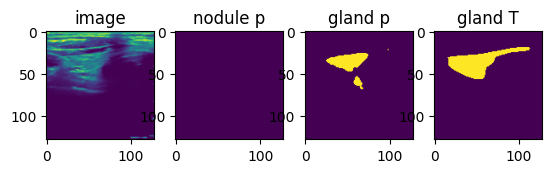

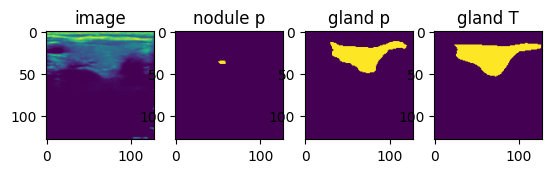

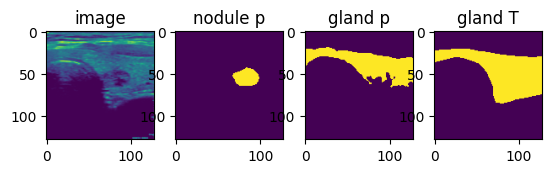

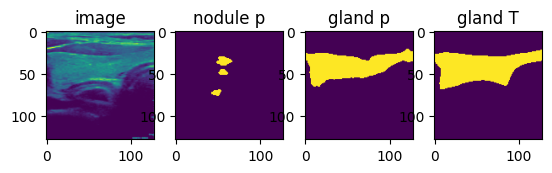

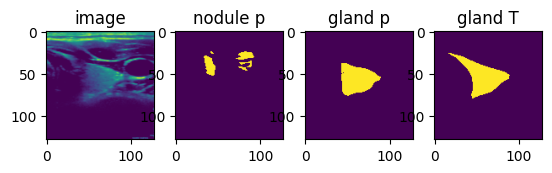

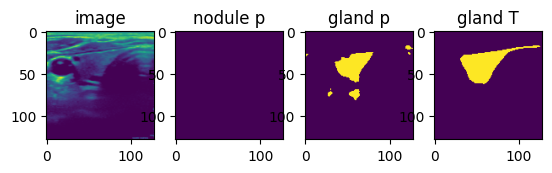

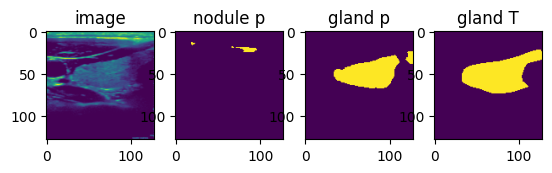

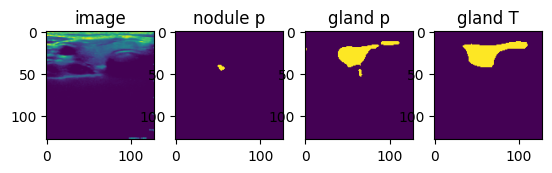

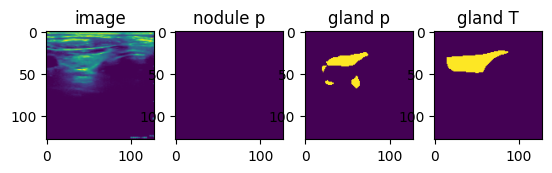

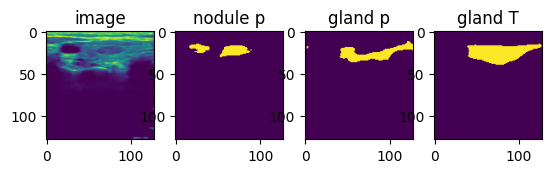

In [18]:
test_dataset = GE_Gland_Dataset("../ge_data/gland/all_data.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
for i in range(10):    
    image, mask, mask_name, image_type = next(iter(test_dataloader))
    model.to("cuda")
    image = image.to("cuda")
    outputs = model(image)

    nodule_output = outputs[:, 0:1, :, :]
    gland_output =  outputs[:, 1:2, :, :]
    nodule_output = torch.sigmoid(nodule_output)
    nodule_output = nodule_output > 0.5
    gland_output = torch.sigmoid(gland_output)
    gland_output = gland_output > 0.5
    
    plt.subplot(1,4,1)
    plt.imshow(image[0][0].detach().cpu().numpy())
    plt.title("image")
    plt.subplot(1,4,2)
    plt.imshow(nodule_output[0][0].detach().cpu().numpy())
    plt.title("nodule p")
    plt.subplot(1,4,3)
    plt.imshow(gland_output[0][0].detach().cpu().numpy())
    plt.title("gland p")
    plt.subplot(1,4,4)
    plt.imshow(mask[0][0])
    plt.title("gland T")
    plt.show()

# visualization for nodule

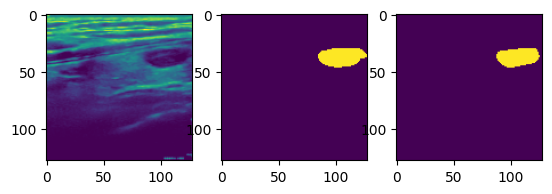

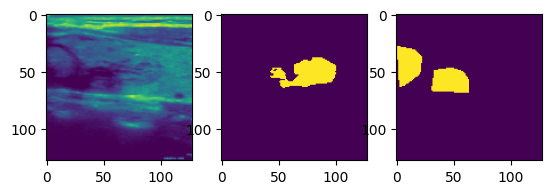

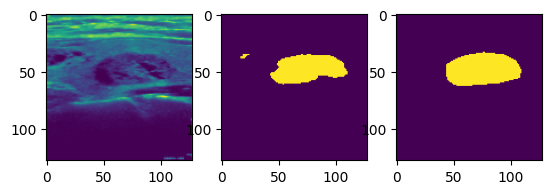

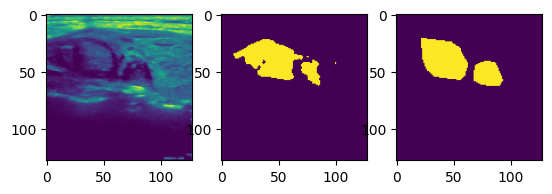

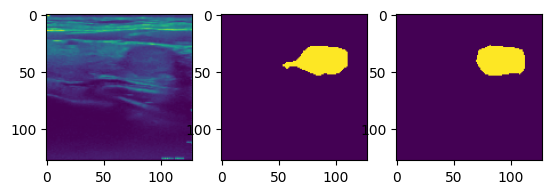

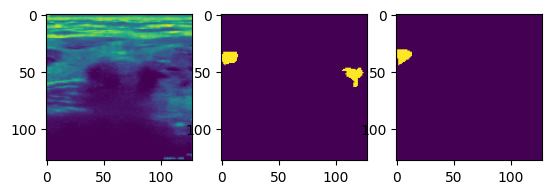

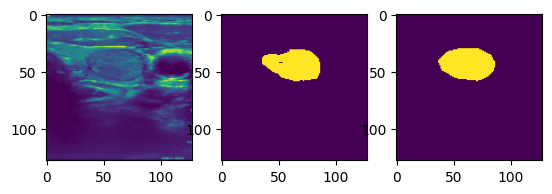

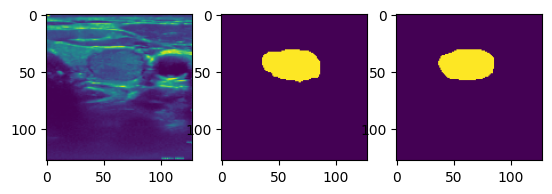

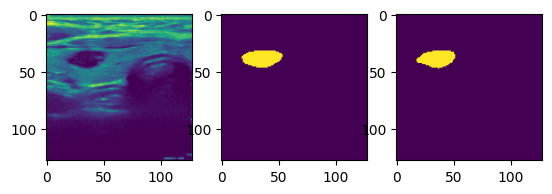

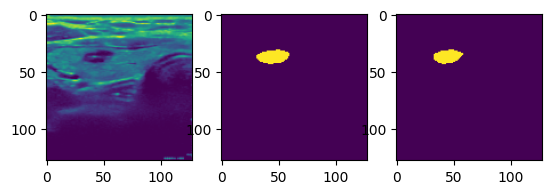

In [21]:
# test_dataset = GE_Gland_Dataset("../ge_data/gland/all_data.csv", transform = test_augmentation, image_size = image_size)
# test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
# for i in range(10):    
#     image, mask, mask_name, image_type = next(iter(test_dataloader))
#     model.to("cuda")
#     image = image.to("cuda")
#     outputs = model(image)

#     nodule_output = outputs[:, 0:1, :, :]
#     gland_output =  outputs[:, 1:2, :, :]
#     nodule_output = torch.sigmoid(nodule_output)
#     nodule_output = nodule_output > 0.5
#     gland_output = torch.sigmoid(gland_output)
#     gland_output = gland_output > 0.5
    
#     plt.subplot(1,4,1)
#     plt.imshow(image[0][0].detach().cpu().numpy())
#     plt.title("image")
#     plt.subplot(1,4,2)
#     plt.imshow(nodule_output[0][0].detach().cpu().numpy())
#     plt.title("nodule p")
#     plt.subplot(1,4,3)
#     plt.imshow(gland_output[0][0].detach().cpu().numpy())
#     plt.title("gland p")
#     plt.subplot(1,4,4)
#     plt.imshow(mask[0][0])
#     plt.title("gland T")
#     plt.show()

In [ ]:
indexs = [9, 15, 2, 8]
for index in indexs:
    
    plt.subplot(1,2,1)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.5)
    plt.title("label")
    
    outputs = outputs>0.5
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
    plt.title("prediction")
    plt.show()

In [ ]:
image.shape

In [ ]:
from_dataset.shape

In [ ]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))

In [ ]:
DDTI_area_ratio = []
TN3K_area_ratio = []
DDTI_image_mean = []
TN3K_image_mean = []
DDTI_image_std = []
TN3K_image_std = []
for image, mask, seg_type, from_dataset in tqdm(test_dataloader):
    for i in range(image.shape[0]):
        if from_dataset[i]==1:
            # plt.imshow(image[i][0])
            # plt.show()
            DDTI_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            DDTI_image_mean.append(torch.mean(image[i][0]))
            DDTI_image_std.append(torch.std(image[i][0]))
        elif from_dataset[i]==3:
            TN3K_area_ratio.append(torch.sum(mask[i][0])/(mask.shape[2]*mask.shape[3]))
            TN3K_image_mean.append(torch.mean(image[i][0]))
            TN3K_image_std.append(torch.std(image[i][0]))

In [ ]:
np.mean(DDTI_image_std)

In [ ]:
np.mean(TN3K_image_std)

In [ ]:
DDTI_image_std

In [ ]:
np.mean(DDTI_area_ratio)

In [ ]:
np.mean(TN3K_area_ratio)

In [ ]:
np.std(DDTI_image_mean)

In [ ]:
np.std(TN3K_image_mean)